# RippleNet_manuscript_figures
Plotting codes for manuscript draft

In [1]:
# allow running on Google Colab, using data on Google Drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My\ Drive/Colab\ Notebooks/NN_Ripple_Detection/neural_networks
    %tensorflow_version 2.x
except:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/NN_Ripple_Detection/neural_networks


In [0]:
%matplotlib inline

In [0]:
import os
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensorflow
from tensorflow import keras
import h5py
from glob import glob
import pandas as pd
import pickle
from matplotlib import colors
from ripplenet.common import *

In [0]:
# make figures appear consistent across plots/notebooks
plt.rcParams.update(rcParams)

In [0]:
# set random seeds
np.random.seed(1234)
tensorflow.random.set_seed(12345)

In [6]:
!ls -l ../data/processed/

total 2683782
-rw------- 1 root root 117615384 Apr 15 19:06 m4029_session1.h5
-rw------- 1 root root 117614180 Apr  1 09:51 m4104_session1.h5
-rw------- 1 root root   8176288 Apr 15 19:12 test_00.h5
-rw------- 1 root root  19294360 Apr 15 19:52 test_buzsaki_00.h5
-rw------- 1 root root  19294360 Apr 15 19:52 test_buzsaki_01.h5
-rw------- 1 root root  19294360 Apr 15 19:52 test_buzsaki_02.h5
-rw------- 1 root root 396836488 Apr 15 19:12 train_00.h5
-rw------- 1 root root 396836488 Apr 15 19:12 train_01.h5
-rw------- 1 root root 396836488 Apr 15 19:12 train_02.h5
-rw------- 1 root root 380385560 Apr 15 19:52 train_buzsaki_00.h5
-rw------- 1 root root 380385560 Apr 15 19:52 train_buzsaki_01.h5
-rw------- 1 root root 380385560 Apr 15 19:52 train_buzsaki_02.h5
-rw------- 1 root root  19116088 Apr 15 19:12 validation_00.h5
-rw------- 1 root root  19116088 Apr 15 19:12 validation_01.h5
-rw------- 1 root root  19116088 Apr 15 19:12 validation_02.h5
-rw------- 1 root root  19294360 Apr 15 19:52

In [0]:
# select species for validation stats (mouse, rat or both)
mouse = True
rat = True

In [0]:
if mouse:
    # load mouse validation datas with labels
    f = h5py.File(os.path.join('..', 'data', 'processed', 'validation_00.h5'), 'r')
    X0 = f['X0'][:] # Raw LFP segments
    X1 = f['X1'][:] # Band-pass filtered LFP segments
    S = f['S'][:] # Wavelet spectrograms
    Y = f['Y'][:] # Numeric labels array
    labels = f['labels'][:]
    all_labels = f['all_labels'][:]
    S_freqs = f['S_freqs'][:]
    f.close()

    # fix dimensionality for test set
    X_val = np.expand_dims(X0, -1)
    Y_val = Y

    # center raw data (only used for visualization)
    X0 = (X0.T - X0.mean(axis=-1)).T

In [0]:
if mouse and rat:
    # load test datas with labels
    f = h5py.File(os.path.join('..', 'data', 'processed', 'validation_buzsaki_00.h5'), 'r')

    X_val = np.concatenate((X_val, np.expand_dims(f['X0'][:], -1)))
    Y_val = np.concatenate((Y_val, f['Y'][:]))

    X0 = np.concatenate((X0, f['X0'][:])) # Raw LFP segments
    X1 = np.concatenate((X1, f['X1'][:])) # Band-pass filtered LFP segments
    S = np.concatenate((S, f['S'][:])) # Wavelet spectrograms
    Y = np.concatenate((Y, f['Y'][:])) # Numeric labels array
    labels = np.concatenate((labels, f['labels'][:]))
    all_labels = np.concatenate((all_labels, f['all_labels'][:]))
    f.close()

    # center raw data (only used for visualization)
    X0 = (X0.T - X0.mean(axis=-1)).T 

In [0]:
if rat and not mouse:
    # load test datas with labels
    f = h5py.File(os.path.join('..', 'data', 'processed', 'validation_buzsaki_00.h5'), 'r')
    
    X0 = f['X0'][:] # Raw LFP segments
    X1 = f['X1'][:] # Band-pass filtered LFP segments
    S = f['S'][:] # Wavelet spectrograms
    Y = f['Y'][:] # Numeric labels array
    labels = f['labels'][:]
    all_labels = f['all_labels'][:]
    S_freqs = f['S_freqs'][:]
    f.close()

    # fix dimensionality for test set
    X_val = np.expand_dims(X0, -1)
    Y_val = Y

    # center raw data (only used for visualization)
    X0 = (X0.T - X0.mean(axis=-1)).T

In [11]:
# shapes of validation input/output
X_val.shape, Y_val.shape

((400, 1250, 1), (400, 1250, 1))

In [0]:
# some needed parameters
n_samples = X0.shape[0] # total number of samples
Fs = 1250 # Hz, sampling freq
time = np.arange(X0.shape[1]) / Fs

In [0]:
# width of boxcar around each labeled event
y_label_width = int(50 * Fs / 1000) # 50 ms @ Fs

In [0]:
# default settings for detecting event from predictions
threshold = 0.5
distance = int(50 * Fs / 1000) # ms @ Fs, peak interdistance
width = int(20 * Fs / 1000) # ms @ Fs, peak width

In [0]:
def annotate_subplot(ax, ncols=1, nrows=1, letter='A',
                     linear_offset=0.025, fontsize=16,
                     fontweight='demibold'):
    '''add a subplot annotation'''
    ax.text(-ncols*linear_offset, 1+nrows*linear_offset, letter,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=fontsize, 
            fontweight=fontweight,
            transform=ax.transAxes)

## Figure 1:

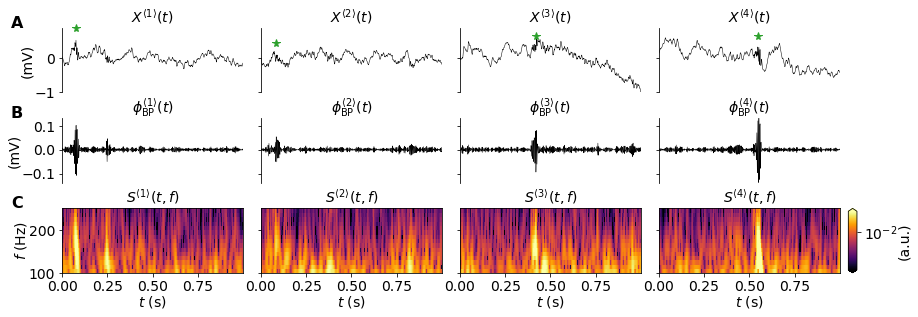

In [16]:
ncols = 4 # number of columns (validation samples) in plot

fig, axes = plt.subplots(3, ncols, figsize=(12, 4), sharey='row', sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.4, left=0.05, right=0.95, top=0.95, bottom=0.1)

for i in range(ncols):
    # raw LFP with ripple label
    ax0 = axes[0, i]
    ax0.plot(time, X_val[i, ] - X_val[i, ].mean(), 'k', lw=0.5,  
             label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    
    idx = all_labels['session'] == labels['session'][i]
    lbls = all_labels['rippleLocs'][idx] - labels[i]['rippleLocs'] - labels[i]['offset']
    inds = lbls[(lbls >= 0) & (lbls < Fs)]
    ax0.plot(time[inds], X_val[i, inds] - X_val[i, ].mean() + 0.4, 'C2d', ms=8, clip_on=False)
    ax0.set_title(r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    if i == 0:
        ax0.set_ylabel('(mV)', labelpad=0)
    ax0.axis(ax0.axis('tight'))
    for spine in ['top', 'bottom', 'right']:
        ax0.spines[spine].set_visible(False)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.xaxis.set_ticks_position('none')    
    

    # band-pass filtered LFP
    ax1 = axes[1, i]
    ax1.plot(time, X1[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
    ax1.set_title(r'$\phi_\mathrm{BP}^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    ax1.axis(ax1.axis('tight'))
    if i == 0:
        ax1.set_ylabel('(mV)', labelpad=0)
    for spine in ['top', 'bottom', 'right']:
        ax1.spines[spine].set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.xaxis.set_ticks_position('none')    
    
    
    # Spectrograms
    ax2 = axes[2, i]

    vmin, vmax = np.exp(np.percentile(np.log(S), [1, 99]))
    im = ax2.pcolormesh(time, S_freqs, S[i, ].T, 
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                        cmap='inferno',
                        label='spectrogram')
    if i == ncols-1:
        rect = np.array(ax2.get_position().bounds)
        rect[0] += rect[2] + 0.01
        rect[2] = 0.01
        fig = plt.gcf()
        cax = fig.add_axes(rect)
        
        cbar = fig.colorbar(im, cax=cax, extend='both')
        cbar.set_label('(a.u.)', labelpad=0)
    ax2.axis(ax2.axis('tight'))
    if i == 0:
        ax2.set_ylabel('$f$ (Hz)', labelpad=0)
    ax2.set_xlabel('$t$ (s)', labelpad=0)
    ax2.set_title(r'$S^{\langle' + '{}'.format(i+1) + r'\rangle}(t,f)$')
    if i == 0:
        annotate_subplot(ax0, ncols=10, nrows=3, letter='A')
        annotate_subplot(ax1, ncols=10, nrows=3, letter='B')
        annotate_subplot(ax2, ncols=10, nrows=3, letter='C')

# save figure
fig.savefig(os.path.join('figures', 'figure1.png'), dpi=300, bbox_inches='tight', pad_inches=0.05)

## load trained networks

In [0]:
# trained neural networks to load

# choose the epoch giving the best performance on validation set, or last training epoch
best = '' #'best_' # or '' #

model_files = [
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed123.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed456.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed789.h5'.format(best)),

    os.path.join('trained_networks', 'ripplenet_bidirectional_{}random_seed123.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_bidirectional_{}random_seed456.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_bidirectional_{}random_seed789.h5'.format(best)),
]
losses_files = [
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed123.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed456.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed789.pkl'),

    os.path.join('trained_networks', 'ripplenet_bidirectional_history_random_seed123.pkl'),
    os.path.join('trained_networks', 'ripplenet_bidirectional_history_random_seed456.pkl'),
    os.path.join('trained_networks', 'ripplenet_bidirectional_history_random_seed789.pkl'),
]

In [18]:
model_files, losses_files

(['trained_networks/ripplenet_unidirectional_random_seed123.h5',
  'trained_networks/ripplenet_unidirectional_random_seed456.h5',
  'trained_networks/ripplenet_unidirectional_random_seed789.h5',
  'trained_networks/ripplenet_bidirectional_random_seed123.h5',
  'trained_networks/ripplenet_bidirectional_random_seed456.h5',
  'trained_networks/ripplenet_bidirectional_random_seed789.h5'],
 ['trained_networks/ripplenet_unidirectional_history_random_seed123.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed456.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed789.pkl',
  'trained_networks/ripplenet_bidirectional_history_random_seed123.pkl',
  'trained_networks/ripplenet_bidirectional_history_random_seed456.pkl',
  'trained_networks/ripplenet_bidirectional_history_random_seed789.pkl'])

In [0]:
# fill up models and losses containers
models = []
losses = []
for i, (mf, pf) in enumerate(zip(model_files, losses_files)):
    models.append(keras.models.load_model(mf))
    with open(pf, 'rb') as f:
        losses.append(pickle.load(f))

In [0]:
# run predictions using all models on the same test set
Y_preds = []
for model in models:
    Y_preds.append(model.predict(X_val))

## figure 2
Visually compare predictions `hat{y}(t)` vs. `y` for samples in figure 1 using different trained networks

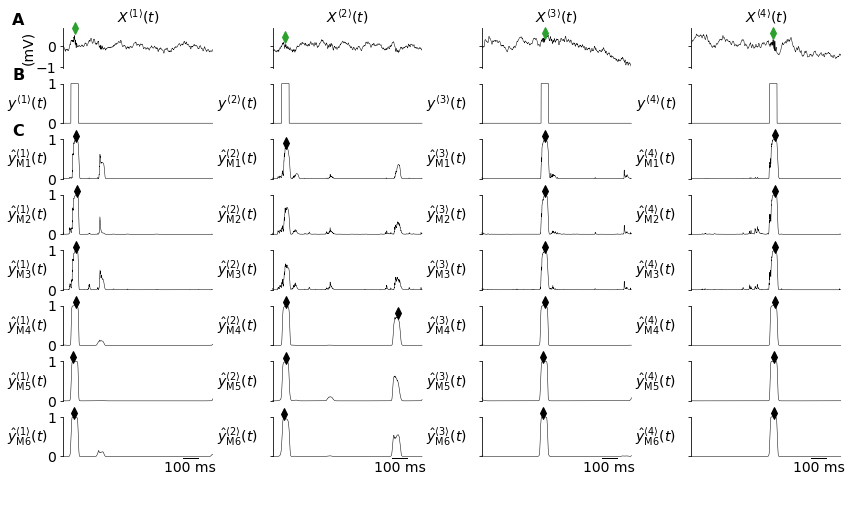

In [39]:
fig = plt.figure(figsize=(12, len(models)+1))
gs = GridSpec(2+len(models), ncols, wspace=0.4, hspace=0.4, left=0.05, right=0.95, top=0.95, bottom=0.1)

for i in range(ncols):
    # raw LFP with ripple label
    if i == 0:
        ax0 = fig.add_subplot(gs[0, i])
    else:
        ax0 = fig.add_subplot(gs[0, i], sharey=ax0)
    ax0.plot(time, X_val[i, ] - X_val[i, ].mean(), 'k', lw=0.5,  
             label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    idx = all_labels['session'] == labels['session'][i]
    lbls = all_labels['rippleLocs'][idx] - labels[i]['rippleLocs'] - labels[i]['offset']
    inds = lbls[(lbls >= 0) & (lbls < Fs)]
    ax0.plot(time[inds], X_val[i, inds] - X_val[i, ].mean()+0.4, 'C2d', ms=8, clip_on=False)

    ax0.set_title(r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
    if i == 0:
        ax0.set_ylabel('(mV)', labelpad=0)
    ax0.axis(ax0.axis('tight'))
    if i > 0:
        plt.setp(ax0.get_yticklabels(), visible=False)
    for spine in ['top', 'bottom', 'right']:
        ax0.spines[spine].set_visible(False)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.xaxis.set_ticks_position('none')    

    # label vector
    ax1 = fig.add_subplot(gs[1, i], sharex=ax0)
    ax1.plot(time, Y_val[i, ], 'k', lw=0.5, clip_on=False)
    ax1.text(time[0]-0.1, 0.5, r'$y^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$', ha='right', va='center')
    ax1.axis(ax1.axis('tight'))
    ax1.set_ylim(0, 1)
    ax1.set_yticks([0, 1])
    if i > 0:
        ax1.set_yticklabels([])
    for spine in ['top', 'bottom', 'right']:
        ax1.spines[spine].set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.xaxis.set_ticks_position('none')

    if i == 0:
        annotate_subplot(ax0, ncols=12, nrows=2+len(models), letter='A')
        annotate_subplot(ax1, ncols=12, nrows=2+len(models), letter='B')

    # show prediction for every model, with asterisks for predicted events
    for j, Y_pred in enumerate(Y_preds):
        # find times of local peaks above threshold
        y = Y_pred[i, :, 0]
        peaks, props = ss.find_peaks(y, height=threshold, distance=distance, width=width)
        
        ax = fig.add_subplot(gs[j+2, i], sharex=ax0)  
        ax.plot(time, y, 'k', lw=0.5, clip_on=False)
        ax.text(time[0]-0.1, 0.5, 
                r'$\hat{y}_\mathrm{M' + '{}'.format(j+1) + '}^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$', 
                ha='right', va='center')
        ax.plot(time[peaks], y[peaks]+.1, 'kd', ms=8, clip_on=False)            
        if j == len(Y_preds)-1:
            ax.plot([0.8, 0.9], [-0.05, -0.05], 'k-', lw=1, clip_on=False)
            ax.text(0.85, -0.1, '100 ms', va='top', ha='center')
        ax.set_ylim(0, 1)
        ax.set_xlim(time[0], time[-1])
        ax.set_yticks([0, 1])
        if i > 0:
            ax.set_yticklabels([])
        for spine in ['top', 'bottom', 'right']:
            ax.spines[spine].set_visible(False)
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.xaxis.set_ticks_position('none')
        
        if (i==0) & (j==0):
            annotate_subplot(ax, ncols=12, nrows=2+len(models), letter='C')


# save figure
fig.savefig(os.path.join('figures', 'figure3.png'), dpi=300, bbox_inches='tight', pad_inches=0.05)

# Quantify performance
Accuracy measures:
```
# Accuracy = (TP + TN) / (TP + TN + FP + FN) # can't quantify count of TN
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2 / (Precision^-1 + Recall^-1)
```

In [22]:
# container for stats
df = pd.DataFrame(columns=['model', 'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1'], dtype='object')

# iterate over models
for i, Y_pred in enumerate(Y_preds):
    # get metrics
    TP, FP, FN, precision, recall, F1 = get_metrics(X_val, Y_val, Y_pred, labels, all_labels,
                                                    threshold, distance, width,
                                                    y_label_width=y_label_width, Fs=Fs)    
    
    # fill in dataframe
    row_df = pd.DataFrame([[i+1, TP, FP, FN, FP+FN, precision, recall, F1]],
                          columns=['model', 'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1'], 
                          dtype='object')
    
    df = pd.concat([df, row_df], axis=0, ignore_index=True)

# display dataframe
df

,model,TP,FP,FN,FP+FN,Precision,Recall,F_1
0,1,520,82,36,118,0.864,0.935,0.898
1,2,493,49,63,112,0.91,0.887,0.898
2,3,512,72,44,116,0.877,0.921,0.898
3,4,528,69,28,97,0.884,0.95,0.916
4,5,517,51,39,90,0.91,0.93,0.92
5,6,518,51,38,89,0.91,0.932,0.921


In [23]:
print(df.to_latex(index=False))

\begin{tabular}{llllllll}
\toprule
model &   TP &  FP &  FN & FP+FN & Precision & Recall &    F\_1 \\
\midrule
    1 &  520 &  82 &  36 &   118 &     0.864 &  0.935 &  0.898 \\
    2 &  493 &  49 &  63 &   112 &      0.91 &  0.887 &  0.898 \\
    3 &  512 &  72 &  44 &   116 &     0.877 &  0.921 &  0.898 \\
    4 &  528 &  69 &  28 &    97 &     0.884 &   0.95 &  0.916 \\
    5 &  517 &  51 &  39 &    90 &      0.91 &   0.93 &   0.92 \\
    6 &  518 &  51 &  38 &    89 &      0.91 &  0.932 &  0.921 \\
\bottomrule
\end{tabular}



## figure 3
Training loss, test metrics

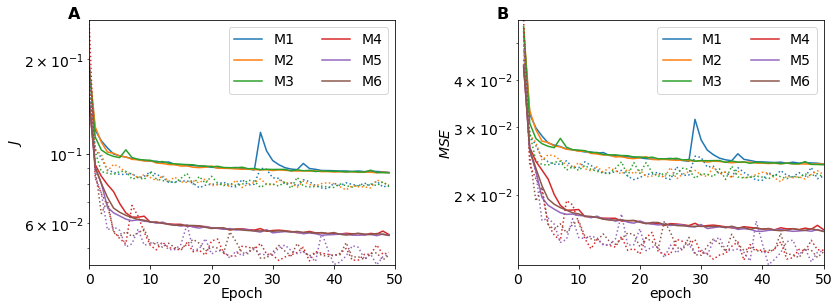

In [24]:
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, wspace=0.4, left=0.1, right=0.95, bottom=0.1, top=0.95)

# plot training loss for the different models
ax0 = fig.add_subplot(gs[0, 0])
for i, loss in enumerate(losses):
    ax0.semilogy(loss['loss'], '-', color='C{}'.format(i), 
                 label='M{}'.format(i+1))
    ax0.semilogy(loss['val_loss'], ':', color='C{}'.format(i), 
                 label='__nolabel__',
                )
ax0.set_ylabel('$J$', labelpad=0)
ax0.legend(ncol=2)
ax0.set_xlabel('Epoch', labelpad=0)
annotate_subplot(ax0, ncols=2, nrows=1, letter='A')


# plot training MSE
ax1 = fig.add_subplot(gs[0, 1], sharex=ax0)
for i, loss in enumerate(losses):
    epochs = np.arange(len(loss['mse']))+1
    ax1.semilogy(epochs, loss['mse'], '-',  color='C{}'.format(i), 
                 label='M{}'.format(i+1))
    ax1.semilogy(epochs, loss['val_mse'], ':', color='C{}'.format(i), 
                 label='__nolabel__'
                )
ax1.set_ylabel('$MSE$', labelpad=0)
ax1.legend(ncol=2)
ax1.set_xlabel('epoch', labelpad=0)
annotate_subplot(ax1, ncols=2, nrows=1, letter='B')

# save figure
fig.savefig(os.path.join('figures', 'figure2.png'), dpi=300, bbox_inches='tight', pad_inches=0.05)

## figure 4
Test dependence of (TP, FP, FN, precision, recall, F1) on threshold and width (ss.find_peaks hyperparameters)

In [0]:
thresholds = np.linspace(0.1, 0.95, 18)
widths = np.linspace(0, 62.5, 11) #.astype(int) # width

In [26]:
widths / Fs * 1000

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [27]:
# container
df = pd.DataFrame(columns=['model', 'threshold', 'width', 'TP', 'FP', 'FN', 'FP+FN', 
                           'Precision', 'Recall', 'F_1'], 
                  dtype='object')

for threshold_ in thresholds:
    for width_ in widths:
        # iterate over models
        for model, Y_pred in enumerate(Y_preds):
            # get metrics
            TP, FP, FN, precision, recall, F1 = get_metrics(X_val, Y_val, Y_pred, labels, all_labels,
                                                            threshold_, distance, width_,
                                                            y_label_width=y_label_width, Fs=Fs)

            # fill in dataframe
            row_df = pd.DataFrame([[model+1, threshold_, width_, TP, FP, FN, FP+FN, precision, recall, F1]],
                                  columns=['model', 'threshold', 'width', 
                                           'TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1'], 
                                  dtype='object')

            df = pd.concat([df, row_df], axis=0, ignore_index=True)

# width in units of ms
df.insert(len(df.columns), 'width (ms)', df['width']*1000 / Fs)

# display dataframe
df

,model,threshold,width,TP,FP,FN,FP+FN,Precision,Recall,F_1,width (ms)
0,1,0.1,0,555,662,6,668,0.456,0.989,0.624,0
1,2,0.1,0,553,880,8,888,0.386,0.986,0.555,0
2,3,0.1,0,553,878,8,886,0.386,0.986,0.555,0
3,4,0.1,0,545,152,15,167,0.782,0.973,0.867,0
4,5,0.1,0,547,162,11,173,0.772,0.98,0.863,0
...,...,...,...,...,...,...,...,...,...,...,...
1183,2,0.95,62.5,36,0,520,520,1,0.065,0.122,50
1184,3,0.95,62.5,40,0,516,516,1,0.072,0.134,50
1185,4,0.95,62.5,249,5,307,312,0.98,0.448,0.615,50
1186,5,0.95,62.5,129,3,427,430,0.977,0.232,0.375,50


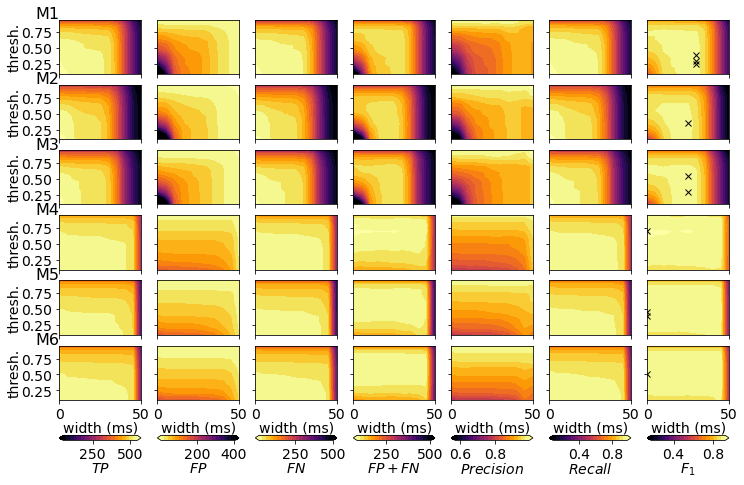

In [28]:
fig, axes = plt.subplots(len(models), 7, figsize=(12, len(models)+1), sharex=True, sharey=True)
from matplotlib.ticker import MaxNLocator

# container for optimal detection settings
df_opt = pd.DataFrame(columns=df.columns)

for j, column in enumerate(['TP', 'FP', 'FN', 'FP+FN', 'Precision', 'Recall', 'F_1']):
    values = [] # container to allow sharing colorbar
    for i in range(len(models)):
        df_ = df[df.model==i+1][['threshold', 'width (ms)', column]]
        df_ = df_.pivot('threshold', 'width (ms)', column)
        values.append(df_.values.astype(float))
        if (i == 0) & (j == 0):
            x, y = np.meshgrid(df_.columns.values, df_.index.values)

    values = np.array(values)
    pc = np.percentile(values.flatten(), [1, 99])
    levels = np.linspace(pc[0], pc[1], 21)
    for i in range(len(models)):
        ax = axes[i, j]
        if j == 0:
            ax.set_ylabel('thresh.', labelpad=0)
            annotate_subplot(ax, ncols=6, nrows=4, letter='M{}'.format(i+1), fontweight='normal')

        df_ = df[df.model==i+1][['threshold', 'width (ms)', column]]
        df_ = df_.pivot('threshold', 'width (ms)', column)
        im = ax.contourf(x, y, values[i], levels=levels, 
                         cmap='inferno_r' if column in ['FP', 'FN', 'FP+FN'] else 'inferno', 
                         extend='both')
        
        if column == 'F_1':
            inds = values[i] == values[i].max()
            for i_, j_ in np.c_[np.where(inds)]:
                df_opt = df_opt.append(df[(df['model']==i+1) &
                                 (df['width (ms)']==x[i_, j_]) &
                                 (df['threshold']==y[i_, j_])],
                             ignore_index=True)
            ax.plot(x[inds], y[inds], 'kx')
            
            
        if i == len(models)-1:
            ax.set_xlabel('width (ms)', labelpad=0)
            rect = np.array(ax.get_position().bounds)
            rect[1] -= 0.08
            rect[3] = 0.01
            fig = plt.gcf()
            cax = fig.add_axes(rect)
            cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
            cbar.locator = MaxNLocator(nbins=2)
            cbar.update_ticks()
            
            cbar.set_label('${}$'.format(column), labelpad=0)

fig.savefig(os.path.join('figures', 'figure4.png'), dpi=300, bbox_inches='tight', pad_inches=0.05)

In [29]:
df_opt

,model,threshold,width,TP,FP,FN,FP+FN,Precision,Recall,F_1,width (ms)
0,1,0.25,37.5,518,71,38,109,0.879,0.932,0.905,30
1,1,0.3,37.5,518,71,38,109,0.879,0.932,0.905,30
2,1,0.4,37.5,517,70,39,109,0.881,0.93,0.905,30
3,2,0.35,31.25,498,47,58,105,0.914,0.896,0.905,25
4,3,0.3,31.25,512,64,44,108,0.889,0.921,0.905,25
5,3,0.55,31.25,505,55,51,106,0.902,0.908,0.905,25
6,4,0.7,0,522,43,36,79,0.924,0.935,0.93,0
7,5,0.4,0,534,63,24,87,0.894,0.957,0.925,0
8,5,0.45,0,527,56,30,86,0.904,0.946,0.925,0
9,6,0.5,0,525,53,32,85,0.908,0.943,0.925,0


In [30]:
print(df_opt.to_latex(index=False))

\begin{tabular}{lllllllllll}
\toprule
model & threshold &  width &   TP &  FP &  FN & FP+FN & Precision & Recall &    F\_1 & width (ms) \\
\midrule
    1 &      0.25 &   37.5 &  518 &  71 &  38 &   109 &     0.879 &  0.932 &  0.905 &         30 \\
    1 &       0.3 &   37.5 &  518 &  71 &  38 &   109 &     0.879 &  0.932 &  0.905 &         30 \\
    1 &       0.4 &   37.5 &  517 &  70 &  39 &   109 &     0.881 &   0.93 &  0.905 &         30 \\
    2 &      0.35 &  31.25 &  498 &  47 &  58 &   105 &     0.914 &  0.896 &  0.905 &         25 \\
    3 &       0.3 &  31.25 &  512 &  64 &  44 &   108 &     0.889 &  0.921 &  0.905 &         25 \\
    3 &      0.55 &  31.25 &  505 &  55 &  51 &   106 &     0.902 &  0.908 &  0.905 &         25 \\
    4 &       0.7 &      0 &  522 &  43 &  36 &    79 &     0.924 &  0.935 &   0.93 &          0 \\
    5 &       0.4 &      0 &  534 &  63 &  24 &    87 &     0.894 &  0.957 &  0.925 &          0 \\
    5 &      0.45 &      0 &  527 &  56 &  30 &    8

## Figure 5

In [31]:
df_opt[df_opt.F_1 == df_opt.F_1.max()]

,model,threshold,width,TP,FP,FN,FP+FN,Precision,Recall,F_1,width (ms)
6,4,0.7,0,522,43,36,79,0.924,0.935,0.93,0


In [0]:
# settings for the "best" model
row = df_opt.F_1 == df_opt.F_1.max()
threshold = df_opt[row].threshold.values[-1]
width = df_opt[row].width.values[-1]
Y_pred = Y_preds[df_opt[row].model.values[-1] - 1]

In [33]:
# which model file
model_files[df_opt[row].model.values[-1] - 1]

'trained_networks/ripplenet_bidirectional_random_seed123.h5'

In [0]:
# write best model info to file for loading in other notebooks
best_model = dict(
    model_file=model_files[df_opt[row].model.values[-1] - 1], 
    threshold=threshold,
    width=width,
    distance=distance,
)
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [0]:
TP, FP, FN, precision, recall, F1 = get_metrics(X_val, Y_val, Y_pred, labels, all_labels,
                                                    threshold, distance, width,
                                                    y_label_width=y_label_width, Fs=Fs)

In [0]:
TPs, FPs, FNs = get_TPs_FPs_FNs(X_val, Y_val, Y_pred, X1, S, labels, all_labels, 
                                threshold, distance, width,
                                Fs=Fs, y_label_width=y_label_width)

In [38]:
# plot validation set entries with mistakes (FP and/or FN predictions)
badinds = np.unique(np.r_[FPs['i'], FNs['i']])

for h in range(badinds.size // ncols):
    inds = badinds[h*ncols:(h+1)*ncols]

    fig, axes = plt.subplots(4, ncols, figsize=(12, 6), 
                            sharex=True, sharey='row')
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.925, wspace=0.1, hspace=0.4, )

    for i, ind in enumerate(inds):
        X_val_ = X_val[ind]
        Y_ = Y[ind, :].flatten()
        y = Y_pred[ind]
        X0_ = X0[ind]
        X1_ = X1[ind]
        S_ = S[ind]

        # Raw LFP + symbols for labels
        axes[0, i].plot(time, X0_, 'k', lw=0.5, label=r'$X^{\langle ' + str(ind)+ r' \rangle}(t)$')
        idx = all_labels['session'] == labels['session'][ind]
        lbls = all_labels['rippleLocs'][idx] - labels[ind]['rippleLocs'] - labels[ind]['offset']
        lblinds = lbls[(lbls >= 0) & (lbls < Fs)]
        axes[0, i].plot(time[lblinds], X0_[lblinds]+0.4, 'C2d', ms=8, clip_on=False)

        for spine in ['top', 'bottom', 'right']:
            axes[0, i].spines[spine].set_visible(False)
        plt.setp(axes[0, i].get_xticklabels(), visible=False)
        axes[0, i].xaxis.set_ticks_position('none')

        
        # band-pass filtered LFP
        axes[1, i].plot(time, X1_, 'k', lw=0.5, label=r'$\phi_\mathrm{BP}^{\langle j \rangle}(t)$')    
        for spine in ['top', 'bottom', 'right']:
            axes[1, i].spines[spine].set_visible(False)
        plt.setp(axes[1, i].get_xticklabels(), visible=False)
        axes[1, i].xaxis.set_ticks_position('none')

        # Spectrograms
        vmin, vmax = np.exp(np.percentile(np.log(S), [1, 99]))
        im = axes[2, i].pcolormesh(time, S_freqs, S_.T, norm=colors.LogNorm(vmin=vmin, vmax=vmax), 
                            cmap='inferno')
        if i == inds.size-1:
            rect = np.array(axes[2, i].get_position().bounds)
            rect[0] += rect[2] + 0.01
            rect[2] = 0.01
            fig = plt.gcf()
            cax = fig.add_axes(rect)
            
            cbar = fig.colorbar(im, cax=cax, extend='both')
            cbar.set_label('(a.u.)', labelpad=0)

        # plot one-hot encoding
        #axes[3, i].plot(time, Y_, 'gray', lw=0.5, label='__nolabel__', clip_on=False)

        # plot \hat{y} + predictions
        axes[3, i].plot(time, y, 'k', lw=0.5, label='__nolabel__', #label='$\hat{y}(t)$', 
                        clip_on=False)

        # mark TP events:
        j = TPs['j'][TPs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, 'C2d', ms=8, label='TP', clip_on=False) 

        # mark FP events:
        j = FPs['j'][FPs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, 'C1d', ms=8, label='FP', clip_on=False) 

        # mark FN events:
        j = FNs['j'][FNs['i'] == ind]
        axes[3, i].plot(time[j], y[j]+0.1, 'C3d', ms=8, label='FN', clip_on=False) 

        if i == ncols-1:
            axes[3, i].legend(frameon=False, bbox_to_anchor=(1.0, 1.0))


        axes[3, i].plot([0.8, 0.9], [-0.05, -0.05], 'k-', lw=1, clip_on=False)
        axes[3, i].text(0.85, -0.1, '100 ms', va='top', ha='center')
        axes[3, i].set_ylim(0, 1.1)
        axes[3, i].set_xlim(time[0], time[-1])
        axes[3, i].set_yticks([0, 1])
        for spine in ['top', 'bottom', 'right']:
            axes[3, i].spines[spine].set_visible(False)
        plt.setp(axes[3, i].get_xticklabels(), visible=False)
        axes[3, i].xaxis.set_ticks_position('none')


        axes[0, i].set_title(r'$X^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        axes[1, i].set_title(r'$\phi_\mathrm{BP}^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        axes[2, i].set_title(r'$S^{\langle ' + str(ind+1)+ r' \rangle}(t, f)$')
        axes[3, i].set_title(r'$\hat{y}^{\langle ' + str(ind+1)+ r' \rangle}(t)$')
        
        if i == 0:
            axes[0, i].set_ylabel('(mV)', labelpad=0)
            axes[1, i].set_ylabel('(mV)', labelpad=0)
            axes[2, i].set_ylabel('$f$ (Hz)', labelpad=0)
            axes[3, i].set_ylabel('$\hat{y}$', labelpad=0)

            annotate_subplot(axes[0, i], ncols=10, nrows=4, letter='A')
            annotate_subplot(axes[1, i], ncols=10, nrows=4, letter='B')
            annotate_subplot(axes[2, i], ncols=10, nrows=4, letter='C')
            annotate_subplot(axes[3, i], ncols=10, nrows=4, letter='D')
    
    fig.savefig(os.path.join('figures', 'figureFPFN_{}.png'.format(h)), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)

Output hidden; open in https://colab.research.google.com to view.